In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import sys

## functions

In [2]:
def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)
    
def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)

def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)

def load_dataframe32(path):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    return result

In [3]:
import xgboost as xgb

class XgbWrapper:
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

class SklearnWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

class CatboostWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
        
class LightGBMWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

## load data

In [5]:
data = load_dataframe32("./bindata/data_013")
data["SK_ID_CURR"] = data.SK_ID_CURR.astype("int")

test = load_dataframe32("./bindata/test_013")
test["SK_ID_CURR"] = test.SK_ID_CURR.astype("int")

y = load_dataframe32("./bindata/y_013")
y["SK_ID_CURR"] = y.SK_ID_CURR.astype("int")

In [57]:
data_train = data[data.SK_ID_CURR < 130000]
data_val = data[(data.SK_ID_CURR >= 130000) & (data.SK_ID_CURR < 150000)]

ydata_train = y[y.SK_ID_CURR < 130000]
ydata_val = y[(y.SK_ID_CURR >= 130000) & (y.SK_ID_CURR < 150000)]

In [7]:
for source_name in (
    "buro_wide_013",
    "buro_full_wide_013",
    "pos_bal_wide_013",
    "cc_bal_wide_013",
    "buro_bal_timestep1_013",
    "buro_bal_timestep2_013",
    "pos_bal_timestep1_013",
    "pos_bal_timestep2_013",
    "cc_bal_timestep1_013",
    "cc_bal_timestep2_013"
):
    target_name = "./bindata/" + source_name + "_nmf5"
    nmf_data = load_dataframe32(target_name)
    nmf_data["SK_ID_CURR"] = nmf_data.SK_ID_CURR.astype("int")
    nmf_data.columns = ["{}_{}".format(source_name, col_) if col_ != "SK_ID_CURR" else col_ for col_ in nmf_data.columns]
    data_train = data_train.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    data_val = data_val.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    del nmf_data
    gc.collect()

buro_wide = load_dataframe32("./bindata/buro_wide_013")
buro_full_wide = load_dataframe32("./bindata/buro_full_wide_013")
pos_bal_wide = load_dataframe32("./bindata/pos_bal_wide_013")
cc_bal_wide = load_dataframe32("./bindata/cc_bal_wide_013")

buro_wide["SK_ID_CURR"] = buro_wide.SK_ID_CURR.astype("int")
buro_full_wide["SK_ID_CURR"] = buro_full_wide.SK_ID_CURR.astype("int")
pos_bal_wide["SK_ID_CURR"] = pos_bal_wide.SK_ID_CURR.astype("int")
cc_bal_wide["SK_ID_CURR"] = cc_bal_wide.SK_ID_CURR.astype("int")

for wi, data_ in enumerate((buro_wide, buro_full_wide, pos_bal_wide, cc_bal_wide)):
    # data_.columns = ["w{}_{}".format(wi, col_) for col_ in data_.columns]
    data_train = data_train.merge(right=data_, how="left", on="SK_ID_CURR")
    data_val = data_val.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()

for name in (
    "./bindata/bureau_and_balance_015",
    "./bindata/previous_applications_015",
    "./bindata/pos_cash_015",
    "./bindata/installments_payments_015",
    "./bindata/credit_card_balance_015",
):
    data_ = load_dataframe32(name)
    data_["SK_ID_CURR"] = data_.SK_ID_CURR.astype("int")
    data_train = data_train.merge(right=data_, how="left", on="SK_ID_CURR")
    data_val = data_val.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()

In [58]:
features = [col_ for col_ in data_train.columns if not col_.startswith("SK_ID")]
print(len(features))

2026


In [11]:
len(set(features))

2026

In [12]:
vc_train = data_train.nunique()
vc_train[vc_train > 1]

SK_ID_CURR                                    25803
NAME_CONTRACT_TYPE                                2
CODE_GENDER                                       2
FLAG_OWN_CAR                                      2
FLAG_OWN_REALTY                                   2
CNT_CHILDREN                                     10
AMT_INCOME_TOTAL                                557
AMT_CREDIT_x                                   2722
AMT_ANNUITY_x                                  6835
AMT_GOODS_PRICE_x                               437
NAME_TYPE_SUITE                                   8
NAME_INCOME_TYPE                                  6
NAME_EDUCATION_TYPE                               5
NAME_FAMILY_STATUS                                5
NAME_HOUSING_TYPE                                 6
REGION_POPULATION_RELATIVE                       80
DAYS_BIRTH                                    12919
DAYS_EMPLOYED                                  6419
DAYS_REGISTRATION                             10729
DAYS_ID_PUBL

In [13]:
features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
print(len(features), len(set(features)))

1889 1889


## train & validate

### xgb -reorder

In [59]:
X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

xgb_params = {
     "objective": "binary:logistic",
     "booster": "gbtree",
     "eval_metric": "auc",
     "nthread": 8,
     "eta": 0.025,
     "max_depth": 6,
     "min_child_weight": 19,
     "gamma": 0,
     "subsample": 0.8,
     "colsample_bytree": 0.632,
     "alpha": 0,
     "lambda": 0.05,
     "nrounds": 250 # 2000
}

xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "nthread": 4,
    "eta": 0.025, # 0.05,
    "max_depth": 6,
    "min_child_weight": 22,
    "gamma": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.675,
    "alpha": 0,
    "lambda": 0,
    "nrounds": 250 #2000
}

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_num_train, y_train)
pred_val = xgb_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.7667830562988245

In [61]:
pred_val_xgb_origin = pred_val

1. 0.76450360090667746

2. 0.76623731737172618 **lb .792 with IDs, param0**

3. 0.76554654483931239 **get rid of IDs, param1 **

4. 0.76608406730783019 **get rid of IDs, param1 **

In [62]:
features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
np.random.seed(0)
np.random.shuffle(features)

X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "nthread": 4,
    "eta": 0.025, # 0.05,
    "max_depth": 6,
    "min_child_weight": 22,
    "gamma": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.675,
    "alpha": 0,
    "lambda": 0,
    "nrounds": 250 #2000
}

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_num_train, y_train)
pred_val = xgb_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.7645436998468242

In [63]:
pred_val_xgb_reorder0 = pred_val

In [68]:
features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
np.random.seed(1)
np.random.shuffle(features)

X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "nthread": 4,
    "eta": 0.025, # 0.05,
    "max_depth": 6,
    "min_child_weight": 22,
    "gamma": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.675,
    "alpha": 0,
    "lambda": 0,
    "nrounds": 250 #2000
}

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_num_train, y_train)
pred_val = xgb_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.766684283977591

In [69]:
pred_val_xgb_reorder1 = pred_val

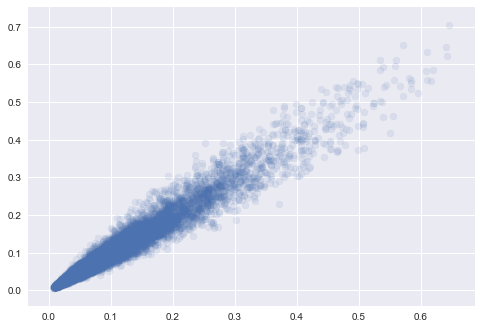

In [70]:
plt.scatter(pred_val_xgb_origin, pred_val_xgb_reorder1, alpha=.1)
plt.show()

In [71]:
roc_auc_score(y_val, pd.Series(pred_val_xgb_origin).rank().values + pd.Series(pred_val_xgb_reorder1).rank().values)

0.7676853807874024

### lgb -reorder

In [15]:
X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 250, # 10000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_num_train, y_train)
pred_val = lg_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.76875957348538315

1. 0.76213752306289995
2. 0.76875957348538315 **current best**

1. 0.75816139082616663
2. 0.76239002619826557 rlimp1
3. 0.76486055795697594 rlimp2
4. 0.76319097794387836 imp1

In [18]:
features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
np.random.seed(0)
np.random.shuffle(features)

X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 250, # 10000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_num_train, y_train)
pred_val = lg_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.76848598289648

In [19]:
pred_val_reorder0 = pred_val 

In [15]:
features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
np.random.seed(123)
np.random.shuffle(features)

X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 250, # 10000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_num_train, y_train)
pred_val = lg_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.7682122174893091

In [17]:
pred_val_reorder123 = pred_val 

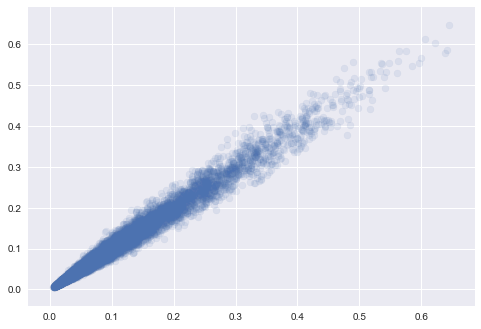

In [21]:
plt.scatter(pred_val_reorder0, pred_val_reorder123, alpha=.1)
plt.show()

In [23]:
roc_auc_score(y_val, pred_val_reorder0 + pred_val_reorder123)

0.7688095278053699

### cat

In [32]:
import catboost

features_selected = list(np.load("./models/features-selected-016.npy"))

X_num_train = data_train[features_selected].values
X_num_val = data_val[features_selected].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

cb_params = {
    "iterations": 250, # 1600,
    "learning_rate": 0.09,
    "depth": 6,
    "bagging_temperature": 0.5,
    "loss_function":'Logloss',
    "eval_metric": 'CrossEntropy',
    "metric_period": 25,
    "rsm": .7,
    "one_hot_max_size": 25,
    "od_type":'Iter',
    "od_wait": 200,
    "random_seed":17,
    "allow_writing_files":False
}

cb_clf = CatboostWrapper(clf=catboost.CatBoostClassifier, params=cb_params)
cb_clf.train(X_num_train, y_train)
pred_val = cb_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0:	learn: 0.6058575	total: 442ms	remaining: 1m 50s
25:	learn: 0.2516039	total: 11.5s	remaining: 1m 38s
50:	learn: 0.2386017	total: 22.2s	remaining: 1m 26s
75:	learn: 0.2310656	total: 33.4s	remaining: 1m 16s
100:	learn: 0.2245440	total: 44.3s	remaining: 1m 5s
125:	learn: 0.2186605	total: 55.2s	remaining: 54.4s
150:	learn: 0.2121879	total: 1m 6s	remaining: 43.3s
175:	learn: 0.2066957	total: 1m 16s	remaining: 32.3s
200:	learn: 0.2014628	total: 1m 27s	remaining: 21.3s
225:	learn: 0.1955981	total: 1m 38s	remaining: 10.5s


0.7642867606979165

1. 0.6974227722820742
2. 0.7628054381068161
3. 0.7642867606979165

## submission

In [24]:
for source_name in (
    "buro_wide_013",
    "buro_full_wide_013",
    "pos_bal_wide_013",
    "cc_bal_wide_013",
    "buro_bal_timestep1_013",
    "buro_bal_timestep2_013",
    "pos_bal_timestep1_013",
    "pos_bal_timestep2_013",
    "cc_bal_timestep1_013",
    "cc_bal_timestep2_013"
):
    target_name = "./bindata/" + source_name + "_nmf5"
    nmf_data = load_dataframe32(target_name)
    nmf_data["SK_ID_CURR"] = nmf_data.SK_ID_CURR.astype("int")
    nmf_data.columns = ["{}_{}".format(source_name, col_) if col_ != "SK_ID_CURR" else col_ for col_ in nmf_data.columns]
    data = data.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    test = test.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    del nmf_data
    gc.collect()
    
buro_wide = load_dataframe32("./bindata/buro_wide_013")
buro_full_wide = load_dataframe32("./bindata/buro_full_wide_013")
pos_bal_wide = load_dataframe32("./bindata/pos_bal_wide_013")
cc_bal_wide = load_dataframe32("./bindata/cc_bal_wide_013")

buro_wide["SK_ID_CURR"] = buro_wide.SK_ID_CURR.astype("int")
buro_full_wide["SK_ID_CURR"] = buro_full_wide.SK_ID_CURR.astype("int")
pos_bal_wide["SK_ID_CURR"] = pos_bal_wide.SK_ID_CURR.astype("int")
cc_bal_wide["SK_ID_CURR"] = cc_bal_wide.SK_ID_CURR.astype("int")

for wi, data_ in enumerate((buro_wide, buro_full_wide, pos_bal_wide, cc_bal_wide)):
    # data_.columns = ["w{}_{}".format(wi, col_) for col_ in data_.columns]
    data = data.merge(right=data_, how="left", on="SK_ID_CURR")
    test = test.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()
    
for name in (
    "./bindata/bureau_and_balance_015",
    "./bindata/previous_applications_015",
    "./bindata/pos_cash_015",
    "./bindata/installments_payments_015",
    "./bindata/credit_card_balance_015",
):
    data_ = load_dataframe32(name)
    data_["SK_ID_CURR"] = data_.SK_ID_CURR.astype("int")
    data = data.merge(right=data_, how="left", on="SK_ID_CURR")
    test = test.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()

In [25]:
data.shape, test.shape, y.shape

((307507, 2030), (48744, 2030), (307507, 2))

### xgb -reorder * 5

In [42]:
a = time.time()

X_data = data[features].values
X_test = test[features].values

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "nthread": 4,
    "eta": 0.025,
    "max_depth": 6,
    "min_child_weight": 22,
    "gamma": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.7,
    "alpha": 0,
    "lambda": 0,
    "nrounds": 2000
}

b = time.time()
print((b - a) / 60)

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_data, y_data)

c = time.time()
print((c - b) / 60)

pred_test = xgb_clf.predict(X_test)
print((time.time() - c) / 60)

(307507, 1889) (48744, 1889)
0.0356520414352417
176.6426033814748
0.09988904396692912


In [76]:
features_selected = list(np.load("./models/features-selected-016.npy"))

a = time.time()

X_data = data[features_selected].values
X_test = test[features_selected].values

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "nthread": 4,
    "eta": 0.02,
    "max_depth": 6,
    "min_child_weight": 22,
    "gamma": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.675,
    "alpha": 0,
    "lambda": 0,
    "nrounds": 2000
}

b = time.time()
print((b - a) / 60)

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_data, y_data)

c = time.time()
print((c - b) / 60)

pred_test = xgb_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/xgb-017-xgb200-eta2-sel", "wb") as ofile:
    pickle.dump(xgb_clf, ofile, 0)
     
np.save("./result/submission-017-xgb2000-eta2-sel", pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-xgb2000-eta2-sel.csv", index=False)

(307507, 1250) (48744, 1250)
0.02158457040786743
146.03246924479802
0.5533149798711141


In [69]:
import pickle

with open("./models/xgb-017-xgb200-eta25", "wb") as ofile:
    pickle.dump(xgb_clf, ofile, 0)

In [43]:
np.save("./result/submission-017-xgb2000-eta25", pred_test)

In [44]:
test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-xgb2000-eta25.csv", index=False)

In [74]:
del X_num_train, X_num_val, data_train, data_val
gc.collect()

254

In [77]:
for seed in range(10000, 10005):
    a = time.time()

    features_selected = list(np.load("./models/features-selected-016.npy"))
    np.random.seed(seed)
    np.random.shuffle(features_selected)

    X_data = data[features_selected].values
    X_test = test[features_selected].values
    gc.collect()

    print("seed", seed)
    print(X_data.shape, X_test.shape)

    y_data = y.TARGET.values

    xgb_params = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "eval_metric": "auc",
        "nthread": 4,
        "eta": 0.02, # 0.05,
        "max_depth": 6,
        "min_child_weight": 22,
        "gamma": 0,
        "subsample": 0.7,
        "colsample_bytree": 0.7,
        "colsample_bylevel": 0.675,
        "alpha": 0,
        "lambda": 0,
        "nrounds": 2000
    }

    b = time.time()

    print((b - a) / 60)

    xgb_clf = XgbWrapper(params=xgb_params)
    xgb_clf.train(X_data, y_data)

    c = time.time()
    print((time.time() - b) / 60)

    pred_test = xgb_clf.predict(X_test)
    print((time.time() - c) / 60)

    import pickle

    with open("./models/xgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
        pickle.dump(xgb_clf, ofile, 0)

    np.save("./result/submission-017-xgb2000-seed{}".format(seed), pred_test)

    test["TARGET"] = pred_test
    test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-xgb2000-seed{}.csv".format(seed), index=False)

seed 10000
(307507, 1250) (48744, 1250)
1.2331538677215577
145.4629200021426
0.07858782609303792
seed 10001
(307507, 1250) (48744, 1250)
0.5095791459083557
143.98351871967316
0.07027068535486856
seed 10002
(307507, 1250) (48744, 1250)
0.017184317111968994
144.26760163704554
0.06942063570022583
seed 10003
(307507, 1250) (48744, 1250)
0.017451000213623048
143.97178471485773
0.07065403858820597
seed 10004
(307507, 1250) (48744, 1250)
0.017050973574320474
144.2359498302142
0.08143798510233562


### lgb -reorder * 5 -> 20

In [37]:
import time
a = time.time()

time.sleep(2)

print(time.time() - a)

2.0011143684387207


In [43]:
del data_train, data_val
gc.collect()

1668

In [44]:
a = time.time()

features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
seed = 0
np.random.seed(seed)
np.random.shuffle(features)

X_data = data[features].values
X_test = test[features].values
gc.collect()

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

(307507, 1889) (48744, 1889)
0.25668134689331057
38.41253041028976
0.1339076558748881


In [45]:
a = time.time()

features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
seed = 1
np.random.seed(seed)
np.random.shuffle(features)

X_data = data[features].values
X_test = test[features].values
gc.collect()

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

(307507, 1889) (48744, 1889)
0.022817973295847574
42.64078891277313
0.1344576915105184


In [46]:
a = time.time()

features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
seed = 233
np.random.seed(seed)
np.random.shuffle(features)

X_data = data[features].values
X_test = test[features].values
gc.collect()

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

(307507, 1889) (48744, 1889)
0.023151326179504394
42.97455800374349
0.13469103574752808


In [48]:
a = time.time()

features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
seed = 666
np.random.seed(seed)
np.random.shuffle(features)

X_data = data[features].values
X_test = test[features].values
gc.collect()

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

(307507, 1889) (48744, 1889)
0.023117987314860027
45.88269100983938
0.13819123506546022


In [47]:
a = time.time()

features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
seed = 67373
np.random.seed(seed)
np.random.shuffle(features)

X_data = data[features].values
X_test = test[features].values
gc.collect()

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

(307507, 1889) (48744, 1889)
0.02348467508951823
42.58193554878235
0.1338743209838867


In [49]:
a = time.time()

features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
seed = 418094
np.random.seed(seed)
np.random.shuffle(features)

X_data = data[features].values
X_test = test[features].values
gc.collect()

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

(307507, 1889) (48744, 1889)
0.0243180513381958
44.07910451889038
0.13480770985285442


In [50]:
a = time.time()

features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
seed = 79
np.random.seed(seed)
np.random.shuffle(features)

X_data = data[features].values
X_test = test[features].values
gc.collect()

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

(307507, 1889) (48744, 1889)
0.024218050638834636
42.479963048299155
0.13582443793614704


In [51]:
a = time.time()

features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
seed = 81
np.random.seed(seed)
np.random.shuffle(features)

X_data = data[features].values
X_test = test[features].values
gc.collect()

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

(307507, 1889) (48744, 1889)
0.02360135316848755
42.09935794274012
0.13264092206954955


In [52]:
a = time.time()

features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
seed = 101
np.random.seed(seed)
np.random.shuffle(features)

X_data = data[features].values
X_test = test[features].values
gc.collect()

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

(307507, 1889) (48744, 1889)
0.02383469740549723
42.149077455202736
0.13494105339050294


In [53]:
a = time.time()

features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
seed = 998
np.random.seed(seed)
np.random.shuffle(features)

X_data = data[features].values
X_test = test[features].values
gc.collect()

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

(307507, 1889) (48744, 1889)
0.02376802364985148
43.20292106866837
0.13270758787790934


In [54]:
a = time.time()

features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
seed = 10001
np.random.seed(seed)
np.random.shuffle(features)

X_data = data[features].values
X_test = test[features].values
gc.collect()

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

(307507, 1889) (48744, 1889)
0.024268054962158205
42.62407129208247
0.13359097242355347


In [55]:
for seed in range(10000, 10010):
    a = time.time()

    features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
    np.random.seed(seed)
    np.random.shuffle(features)

    X_data = data[features].values
    X_test = test[features].values
    gc.collect()

    print("seed", seed)
    print(X_data.shape, X_test.shape)

    y_data = y.TARGET.values

    lgb_params =  {
        "nthread": 8,
        "n_estimators": 2000,
        "learning_rate": 0.02,
        "num_leaves": 34,
        "colsample_bytree": 0.9497036,
        "subsample": 0.8715623,
        "subsample_freq": 1,
        "max_depth": 8,
        "reg_alpha": 0.041545473,
        "reg_lambda": 0.0735294,
        "min_split_gain": 0.0222415,
        "min_child_weight": 39.3259775,
        "random_state": 0,
        "silent": -1,
        "verbose": -1
    }

    b = time.time()

    print((b - a) / 60)

    lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
    lg_clf.train(X_data, y_data)

    c = time.time()
    print((time.time() - b) / 60)

    pred_test = lg_clf.predict(X_test)
    print((time.time() - c) / 60)

    import pickle

    with open("./models/lgb-017-nround2000-seed{}".format(seed), "wb") as ofile:
        pickle.dump(lg_clf, ofile, 0)

    np.save("./result/submission-017-lgb2000-seed{}".format(seed), pred_test)

    test["TARGET"] = pred_test
    test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-seed{}.csv".format(seed), index=False)

seed 10000
(307507, 1889) (48744, 1889)
0.024284716447194418
42.47986304759979
0.13719118038813274
seed 10001
(307507, 1889) (48744, 1889)
0.02425138552983602
43.10776562690735
0.1361744523048401
seed 10002
(307507, 1889) (48744, 1889)
0.02415138085683187
42.486930112044014
0.13649113972981772
seed 10003
(307507, 1889) (48744, 1889)
0.023984710375467937
42.73541098833084
0.13565775950749714
seed 10004
(307507, 1889) (48744, 1889)
0.024101380507151285
41.824508889516196
0.13502439260482788
seed 10005
(307507, 1889) (48744, 1889)
0.02401803731918335
43.09564826488495
0.14500829378763835
seed 10006
(307507, 1889) (48744, 1889)
0.023918036619822183
43.03636153936386
0.13419100840886433
seed 10007
(307507, 1889) (48744, 1889)
0.024418063958485923
42.73064405123393
0.14115807215372722
seed 10008
(307507, 1889) (48744, 1889)
0.024518068631490073
42.44442768096924
0.13494105339050294
seed 10009
(307507, 1889) (48744, 1889)
0.024084711074829103
42.5939195672671
0.13552441596984863


### lgb -fs

In [78]:
a = time.time()

features_selected = list(np.load("./models/features-selected-016.npy"))
seed = 0


X_data = data[features_selected].values
X_test = test[features_selected].values
gc.collect()

print("seed", seed)
print(X_data.shape, X_test.shape)

y_data = y.TARGET.values


lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

import pickle

with open("./models/lgb-017-nround2000-fs{}".format(seed), "wb") as ofile:
    pickle.dump(lg_clf, ofile, 0)

np.save("./result/submission-017-lgb2000-fs{}".format(seed), pred_test)

test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-fs{}.csv".format(seed), index=False)

seed 0
(307507, 1250) (48744, 1250)
0.02930167516072591
24.239969778060914
0.10718946854273478


In [79]:
for seed in range(10000, 10010):
    a = time.time()

    features_selected = list(np.load("./models/features-selected-016.npy"))
    np.random.seed(seed)
    np.random.shuffle(features)

    X_data = data[features_selected].values
    X_test = test[features_selected].values
    gc.collect()

    print("seed", seed)
    print(X_data.shape, X_test.shape)

    y_data = y.TARGET.values


    lgb_params =  {
        "nthread": 8,
        "n_estimators": 2000,
        "learning_rate": 0.02,
        "num_leaves": 34,
        "colsample_bytree": 0.9497036,
        "subsample": 0.8715623,
        "subsample_freq": 1,
        "max_depth": 8,
        "reg_alpha": 0.041545473,
        "reg_lambda": 0.0735294,
        "min_split_gain": 0.0222415,
        "min_child_weight": 39.3259775,
        "random_state": 0,
        "silent": -1,
        "verbose": -1
    }

    b = time.time()

    print((b - a) / 60)

    lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
    lg_clf.train(X_data, y_data)

    c = time.time()
    print((time.time() - b) / 60)

    pred_test = lg_clf.predict(X_test)
    print((time.time() - c) / 60)

    import pickle

    with open("./models/lgb-017-nround2000-fs{}".format(seed), "wb") as ofile:
        pickle.dump(lg_clf, ofile, 0)

    np.save("./result/submission-017-lgb2000-fs{}".format(seed), pred_test)

    test["TARGET"] = pred_test
    test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-lgb2000-fs{}.csv".format(seed), index=False)

seed 10000
(307507, 1250) (48744, 1250)
0.017751018206278484
24.18558333714803
0.11123969554901122
seed 10001
(307507, 1250) (48744, 1250)
0.016084253787994385
23.66760370731354
0.11190640131632487
seed 10002
(307507, 1250) (48744, 1250)
0.015484221776326497
23.99932268063227
0.12199030717213949
seed 10003
(307507, 1250) (48744, 1250)
0.015667561690012613
24.067993275324504
0.11959017515182495
seed 10004
(307507, 1250) (48744, 1250)
0.015500887235005697
23.9698543270429
0.11160638729731241
seed 10005
(307507, 1250) (48744, 1250)
0.01565089225769043
23.99047217766444
0.11425653298695883
seed 10006
(307507, 1250) (48744, 1250)
0.0159009059270223
23.85713121891022
0.11168972253799439
seed 10007
(307507, 1250) (48744, 1250)
0.016050918896993
23.960703806082407
0.1096062699953715
seed 10008
(307507, 1250) (48744, 1250)
0.015884240468343098
24.39902888139089
0.11067299445470175
seed 10009
(307507, 1250) (48744, 1250)
0.01658428112665812
25.67258505423864
0.11320647001266479


### cat

In [27]:
import catboost

X_data = data[features].values
X_test = test[features].values

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

cb_params = {
    "iterations": 2000, # 1600,
    "learning_rate": 0.02,
    "depth": 6,
    "bagging_temperature": 0.5,
    "loss_function":'Logloss',
    "eval_metric": 'CrossEntropy',
    "metric_period": 25,
    "rsm": .7,
    "od_type":'Iter',
    "od_wait": 200,
    "random_seed":17,
    "allow_writing_files":False
}

cb_clf = CatboostWrapper(clf=catboost.CatBoostClassifier, params=cb_params)
cb_clf.train(X_data, y_data)
pred_test = cb_clf.predict(X_test)

(307507, 1889) (48744, 1889)
0:	learn: 0.6701972	total: 2.09s	remaining: 1h 9m 38s
25:	learn: 0.3677380	total: 57.6s	remaining: 1h 12m 53s
50:	learn: 0.2868992	total: 1m 52s	remaining: 1h 11m 36s
75:	learn: 0.2617818	total: 2m 45s	remaining: 1h 10m
100:	learn: 0.2525575	total: 3m 41s	remaining: 1h 9m 33s
125:	learn: 0.2484336	total: 4m 35s	remaining: 1h 8m 16s
150:	learn: 0.2461474	total: 5m 28s	remaining: 1h 7m 7s
175:	learn: 0.2445893	total: 6m 22s	remaining: 1h 6m 3s
200:	learn: 0.2434715	total: 7m 15s	remaining: 1h 5m
225:	learn: 0.2425717	total: 8m 9s	remaining: 1h 3m 59s
250:	learn: 0.2417619	total: 9m 2s	remaining: 1h 2m 58s
275:	learn: 0.2410468	total: 9m 56s	remaining: 1h 2m 4s
300:	learn: 0.2404033	total: 10m 49s	remaining: 1h 1m 5s
325:	learn: 0.2397610	total: 11m 42s	remaining: 1h 9s
350:	learn: 0.2392366	total: 12m 36s	remaining: 59m 13s
375:	learn: 0.2387255	total: 13m 29s	remaining: 58m 17s
400:	learn: 0.2382566	total: 14m 22s	remaining: 57m 19s
425:	learn: 0.2378166	tot

In [28]:
import pickle

with open("./models/xgb-017-cat2000", "wb") as ofile:
    pickle.dump(cb_clf, ofile, 0)

In [29]:
np.save("./result/submission-017-cat2000", pred_test)

In [30]:
test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-cat2000.csv", index=False)

### ensemble

In [31]:
pred_test14 = np.load("./result/submission-014.npy")

In [35]:
test["TARGET"] = (pred_test14 + pred_test) / 2
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-016-ensemble.csv", index=False)

In [45]:
pred_test16lgb = np.load("./result/submission-016-lgb2000.npy")
pred_test16xgb = np.load("./result/submission-016-xgb2000-eta25.npy")

In [46]:
test["TARGET"] = (pred_test16lgb + pred_test16xgb) / 2
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-016-ensemble-eta25.csv", index=False)

In [48]:
pred_test16lgb = np.load("./result/submission-016-lgb2000.npy")
pred_test16xgb = np.load("./result/submission-016-xgb2000-eta25.npy")

a = pd.Series(pred_test16lgb).rank().values
b = pd.Series(pred_test16xgb).rank().values

In [52]:
test["TARGET"] = (a + b) / (a.max() + b.max())
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-016-rank-eta25.csv", index=False)

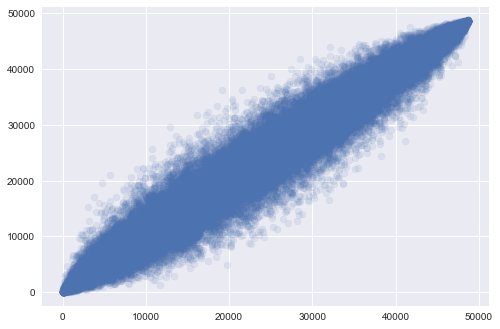

In [50]:
plt.scatter(a, b, alpha=.1)
plt.show()

#### mix 3

In [31]:
pred_test16lgb = np.load("./result/submission-016-lgb2000.npy")
pred_test16xgb = np.load("./result/submission-016-xgb2000-eta25.npy")
pred_test16cat = np.load("./result/submission-016-cat1600.npy")

a = pd.Series(pred_test16lgb).rank().values
b = pd.Series(pred_test16xgb).rank().values
c = pd.Series(pred_test16cat).rank().values

In [35]:
test["TARGET"] = (a + b + c) / (a.max() + b.max() + c.max())
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-016-rank-mix3.csv", index=False)

In [36]:
test["TARGET"] = (4 * a + 3 * b + 1 * c) / (4 * a.max() + 3 * b.max() + 1 * c.max())
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-016-rank-weighted.csv", index=False)

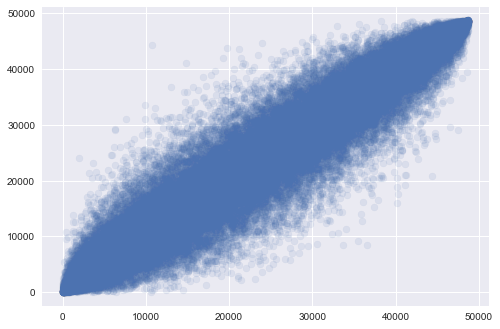

In [34]:
plt.scatter(a, c, alpha=.1)
plt.show()

In [62]:
data.shape

(307507, 2030)

In [63]:
datanull_vc = data.isnull().sum()

In [64]:
data.shape[0] * .75

230630.25

In [67]:
datanull_vc[datanull_vc > data.shape[0] * .75].shape

(440,)

In [59]:
pd.Series(lg_clf.clf.feature_importances_).value_counts()

0      445
1       99
2       64
3       43
4       34
11      31
12      28
7       28
18      27
14      27
19      26
16      26
22      26
10      26
25      24
20      24
17      24
9       24
6       24
15      23
21      23
5       22
13      22
24      20
23      19
27      18
28      18
50      18
30      16
8       16
      ... 
141      1
181      1
133      1
757      1
93       1
106      1
110      1
123      1
124      1
64       1
128      1
129      1
130      1
131      1
132      1
137      1
175      1
142      1
144      1
147      1
150      1
151      1
157      1
158      1
161      1
162      1
163      1
168      1
170      1
876      1
Length: 189, dtype: int64

#### mix with kernel

In [32]:
submission_kernel = pd.read_csv("./result/submission_kernel02.csv")
submission_kernel.head()

,SK_ID_CURR,TARGET
0,100001,0.033167
1,100005,0.119856
2,100013,0.025908
3,100028,0.037410
4,100038,0.140051


In [33]:
d = pd.Series(submission_kernel.TARGET.values).rank().values

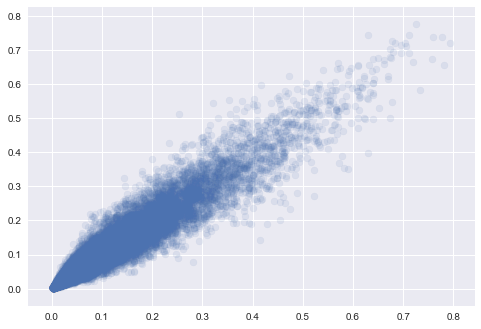

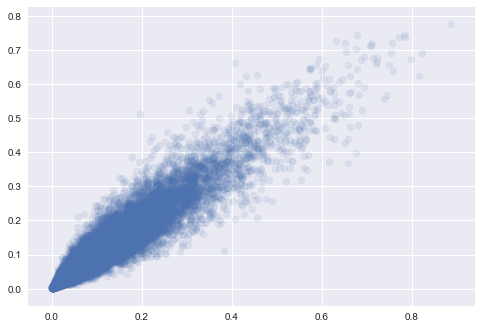

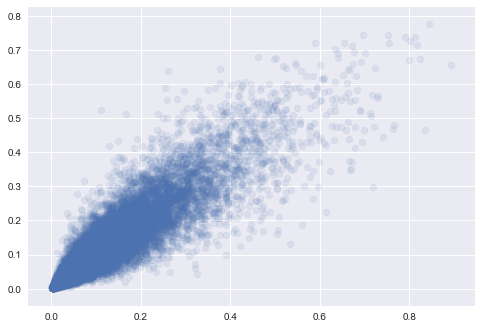

In [42]:
for pred_ in (
    pred_test16lgb,
    pred_test16xgb,
    pred_test16cat,
):
    plt.scatter(pred_, d, alpha=.1)
    plt.show()

In [44]:
test["TARGET"] = (4 * a + 3 * b + 1 * c + 5 * d) / (4 * a.max() + 3 * b.max() + 1 * c.max() + 5 * d.max())
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-016-rank-kernel.csv", index=False)

#### mix with kernel2

In [35]:
test["TARGET"] = (4 * a + 1 * b + 5 * d) / (4 * a.max() + 1 * b.max() + 5 * d.max())
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-017-rank-kernel2.csv", index=False)

## feature selection

In [74]:
lg_clf.clf.feature_importances_.shape

(1889,)

In [81]:
features_selected = []
for ftr_, (null_cnt_, imp_) in zip(features,zip(datanull_vc[features].values, lg_clf.clf.feature_importances_)):
    if null_cnt_ >= data.shape[0] * .75 or imp_ <= 0:
        continue
    features_selected.append(ftr_)
print(len(features_selected))

1250


In [82]:
np.save("./models/features-selected-016", features_selected)

### lgb -selected

In [84]:
X_num_train = data_train[features_selected].values
X_num_val = data_val[features_selected].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 250, # 10000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_num_train, y_train)
pred_val = lg_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.7685096270671824

### et -selected

In [85]:
from sklearn.ensemble import ExtraTreesClassifier

In [100]:
X_num_train = data_train[features_selected].values.astype(np.float32)
X_num_val = data_val[features_selected].values.astype(np.float32)

X_num_train[X_num_train < np.Inf].max(), X_num_train[X_num_train > -np.Inf].min()

C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in less
C:\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in greater


(3.6449999e+11, -3913034.0)

In [103]:
X_num_train = data_train[features_selected].values.astype(np.float32)
X_num_val = data_val[features_selected].values.astype(np.float32)

X_num_train[np.isnan(X_num_train)] = -1
X_num_train[X_num_train > 3.6449999e+11] = 3.6449999e+11
X_num_train[X_num_train < -3913034] = -3913034

X_num_val[np.isnan(X_num_val)] = -1
X_num_val[X_num_val > 3.6449999e+11] = 3.6449999e+11
X_num_val[X_num_val < -3913034] = -3913034


y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values


et_params = {
    'n_jobs': 8,
    'n_estimators': 200,
    'max_features': 0.5,
    'max_depth': 10,
    'min_samples_leaf': 100,
}

print(np.isnan(X_num_train).sum(), X_num_train.max(), X_num_train.min())
print(np.isnan(X_num_val).sum(), X_num_val.max(), X_num_val.min())

et_clf = SklearnWrapper(clf=ExtraTreesClassifier, params=et_params)
et_clf.train(X_num_train, y_train)
pred_val = et_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0 3.645e+11 -3.91303e+06
0 3.645e+11 -3.91303e+06


0.74009269913461462

### rf -selected

In [104]:
from sklearn.ensemble import RandomForestClassifier

In [107]:
X_num_train = data_train[features_selected].values.astype(np.float32)
X_num_val = data_val[features_selected].values.astype(np.float32)

X_num_train[np.isnan(X_num_train)] = -1
X_num_train[X_num_train > 3.6449999e+11] = 3.6449999e+11
X_num_train[X_num_train < -3913034] = -3913034

X_num_val[np.isnan(X_num_val)] = -1
X_num_val[X_num_val > 3.6449999e+11] = 3.6449999e+11
X_num_val[X_num_val < -3913034] = -3913034

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

rf_params = {
    'n_jobs': 8,
    'n_estimators': 200,
    'max_features': 0.2,
    'max_depth': 8,
    'min_samples_leaf': 40,
}

print(np.isnan(X_num_train).sum(), X_num_train.max(), X_num_train.min())
print(np.isnan(X_num_val).sum(), X_num_val.max(), X_num_val.min())

et_clf = SklearnWrapper(clf=RandomForestClassifier, params=rf_params)
et_clf.train(X_num_train, y_train)
pred_val = et_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0 3.645e+11 -3.91303e+06
0 3.645e+11 -3.91303e+06


0.73890424084642814